In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models
#from torchsummary import summary
from torch.optim import lr_scheduler
from torchvision.models.resnet import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

# Dataset
from GeoGuessrDataset import GeoGuessrDataset


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tnrange
import time
import copy
import pygeohash as phg


%matplotlib inline

# Enable autoreloading of imported modules.
%load_ext autoreload
%autoreload 2

In [31]:
dir = r"C:\Users\Shadow\Documents\sequentialmodel\preprocess"
ROOT_DIR = r'C:\Users\Shadow\Pictures\Geogussr\Projekt'
transform2 = transforms.Compose([transforms.ToTensor(),transforms.Resize((250, 1000))])
transform = transforms.Compose([
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # normalize images
    transforms.Resize((250, 1000))
])
dataset = GeoGuessrDataset(csv_file=dir+'\coordinates3.csv',
                                    root_dir=ROOT_DIR, transform=transform, num_classes=7)

printset = GeoGuessrDataset(csv_file=dir+'\coordinates3.csv',
                                    root_dir=ROOT_DIR, transform=transform2, num_classes=7)
dataset[0]['image'].shape

torch.Size([3, 250, 1000])

In [5]:
import pygeohash
def decimal_to_geohash(decimal):
    base_32 = '0123456789bcdefghjkmnpqrstuvwxyz'
    geohash = ''
    while decimal > 0:
        geohash += base_32[decimal % 32]
        decimal //= 32
    return geohash[::-1]

def geohash_to_lat_lon(geohash):
    return pygeohash.decode(geohash)

In [6]:
def create_geocode_mapping(path, continent_name = None):
    """Create a dictionary with the geo_code as key and the geohash (decimal) as value
    Args:
        path (str): Path to the csv file with the coordinates
    Returns:
        dict: Dictionary with the geo_code as key and the geohash (decimal) as value
    """
    
    df = pd.read_csv(path)
    df_geo = df[["geohash_decimal", "geo_code"]]
    df_geo = df_geo.drop_duplicates()
    geohashes_with_samples = df_geo["geohash_decimal"]
    
    
    
    if continent_name:
        # get csv to only contain one continent
        keys = df["continent"].unique()
        indices = {key: df.index[df["continent"]==key].tolist()for key in keys}
        df = df.iloc[indices[continent_name]]

        # We want a geohash precsion of 3 so that we get approximately 32768 cells, which will represent our classes.
        df['geohash']=df.apply(lambda coords: phg.encode(coords.latitude, coords.longitude, precision=3), axis=1)

        # get all hashes that contain samples
        geohashes_with_samples = df["geo_code"].unique() 
    return geohashes_with_samples

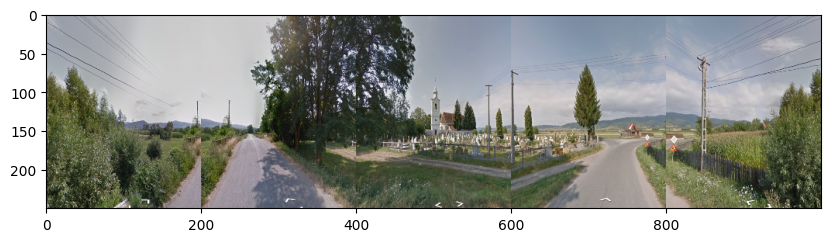

In [32]:
i = 90000
image_transformed = printset[i]['image']

plt.figure(figsize=(10, 10))
 

plt.imshow(image_transformed.permute(1, 2, 0))

# Conti

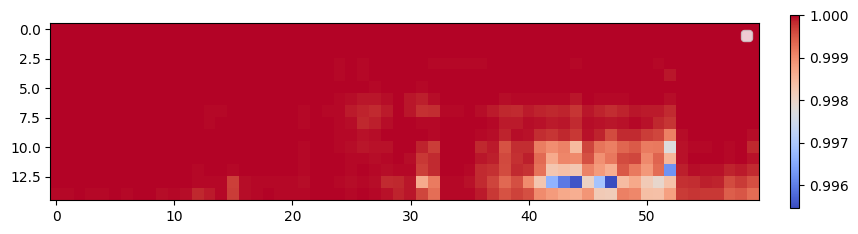

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


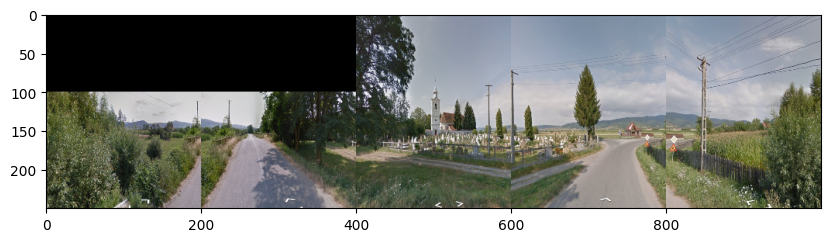

In [42]:
from haversine import haversine
# Load the model
#aspect ration of 4 to 1
w_size = 400
h_size = 100

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

checkpoint = torch.load(r"C:\Users\Shadow\Documents\sequentialmodel\models\pretrainedresnet50_14epoch_contihead.tar", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#transform = transforms.Compose([transforms.ToTensor()])

image_transformed, conti = dataset[i]['image'], dataset[i]['conti']
heatmap = []
for h in range(int((250-h_size)/10)):
    for w in range(int((1000-w_size)/10)):
        with torch.inference_mode():
            # TODO: Why does the output tensor have 2 dimensions and why do we have to unsqueeze(0) add one dimension?
            # Probably because the model expects a batch of images, which adds an additional dimension?
            image_covered = image_transformed.clone()
            grey = torch.ones(3,h_size,w_size)*-0.5
            image_covered[0:3,h*10:h*10+h_size,w*10:w*10+w_size] = grey
            #plt.imshow(image_covered.permute(1, 2, 0))
            #plt.show()
            output = model(image_covered.unsqueeze(0))[0]
            

            ############################# new stuff
            _, pred = torch.max(output,-1)
            #print(pred)
            v = np.argmax(conti)
            prediction_confidence = nn.functional.softmax(output, dim=0)
            #print(v)
            heatmap.append(prediction_confidence[v])
            

            
heatmap = np.array(heatmap).reshape(int((250-h_size)/10),int((1000-w_size)/10))           



grey = torch.ones(100,400,3)*-0.5

plt.figure(figsize=(10, 10))
im = plt.imshow(heatmap, cmap='coolwarm')

# Add a color bar
cb = plt.colorbar(im, fraction=0.046, pad=0.04, shrink=0.25)

# Add a legend
plt.legend(["Values"])

# Show the plot
plt.show()
plt.figure(figsize=(10, 10))
h = printset[i]['image'].permute(1, 2, 0)
h[0:100,0:400,0:3] = grey
plt.imshow(h)

# All


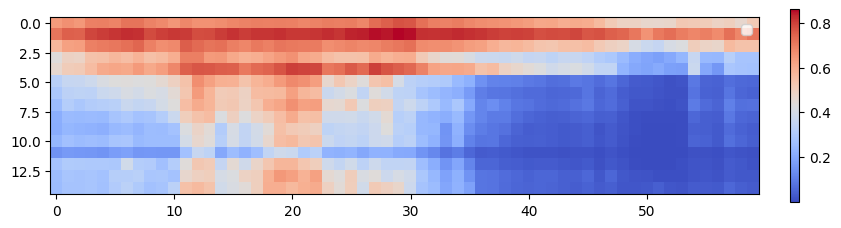

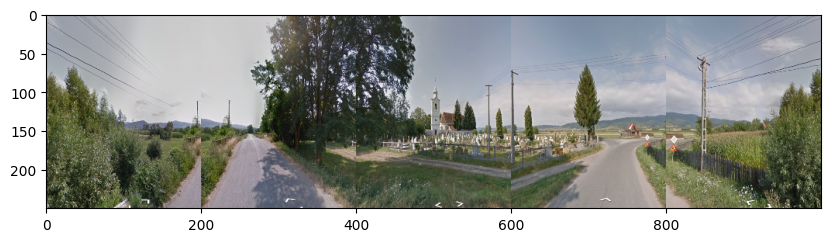

In [33]:
from haversine import haversine
# Load the model
#aspect ration of 4 to 1
w_size = 400
h_size = 100

model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3139)

checkpoint = torch.load(r"C:\Users\Shadow\Documents\sequentialmodel\models\pretrainedresnet50_20epoch_all.tar", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#transform = transforms.Compose([transforms.ToTensor()])

image_transformed, geohash = dataset[i]['image'], dataset[i]['geohash']
heatmap = []
for h in range(int((250-h_size)/10)):
    for w in range(int((1000-w_size)/10)):
        with torch.inference_mode():
            # TODO: Why does the output tensor have 2 dimensions and why do we have to unsqueeze(0) add one dimension?
            # Probably because the model expects a batch of images, which adds an additional dimension?
            image_covered = image_transformed.clone()
            grey = torch.ones(3,h_size,w_size)*-0.5
            image_covered[0:3,h*10:h*10+h_size,w*10:w*10+w_size] = grey
            #plt.imshow(image_covered.permute(1, 2, 0))
            #plt.show()
            output = model(image_covered.unsqueeze(0))[0]
            

            ############################# new stuff
            
            v = np.argmax(geohash)
            prediction_confidence = nn.functional.softmax(output, dim=0)
            heatmap.append(prediction_confidence[v])
            

            
heatmap = np.array(heatmap).reshape(int((250-h_size)/10),int((1000-w_size)/10))           



grey = torch.ones(100,400,3)*-0.5

plt.figure(figsize=(10, 10))
im = plt.imshow(heatmap, cmap='coolwarm')

# Add a color bar
cb = plt.colorbar(im, fraction=0.046, pad=0.04, shrink=0.25)

# Add a legend
plt.legend(["Values"])

# Show the plot
plt.show()
plt.figure(figsize=(10, 10))
h = printset[i]['image'].permute(1, 2, 0)
#h[0:100,0:400,0:3] = grey
plt.imshow(h)

# Local


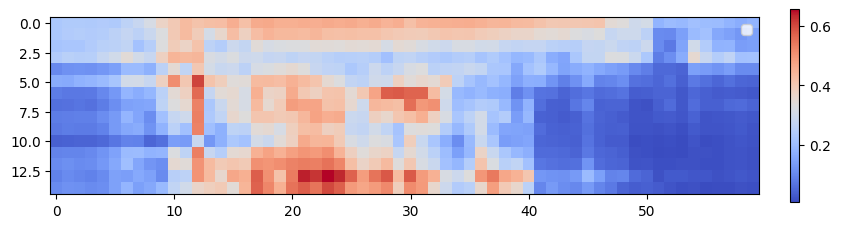

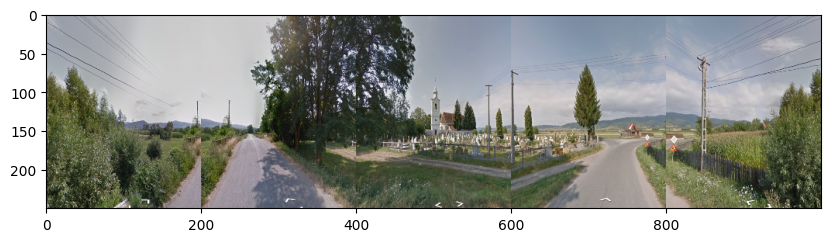

In [44]:
from haversine import haversine
# Load the model
#aspect ration of 4 to 1
w_size = 400
h_size = 100
geohashes_with_samples = create_geocode_mapping(r"C:\Users\Shadow\Documents\sequentialmodel\preprocess\coordinates3.csv",'Europe')


model = models.resnet50()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 745)

checkpoint = torch.load(r"C:\Users\Shadow\Documents\sequentialmodel\models\pretrainedresnet50_14epoch_Europe.tar", map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

#transform = transforms.Compose([transforms.ToTensor()])

image_transformed, geohash = dataset[i]['image'], dataset[i]['geohash']
heatmap = []
for h in range(int((250-h_size)/10)):
    for w in range(int((1000-w_size)/10)):
        with torch.inference_mode():
            # TODO: Why does the output tensor have 2 dimensions and why do we have to unsqueeze(0) add one dimension?
            # Probably because the model expects a batch of images, which adds an additional dimension?
            image_covered = image_transformed.clone()
            grey = torch.ones(3,h_size,w_size)*-0.5
            image_covered[0:3,h*10:h*10+h_size,w*10:w*10+w_size] = grey
            #plt.imshow(image_covered.permute(1, 2, 0))
            #plt.show()
            output = model(image_covered.unsqueeze(0))[0]
            

            ############################# new stuff
            
            v = np.argmax(geohash)
            
            
            geohashes_with_samples = np.array(geohashes_with_samples)
            
            
            v = np.where(geohashes_with_samples == v.item())
            
            prediction_confidence = nn.functional.softmax(output, dim=0)
            
            heatmap.append(prediction_confidence[v].item())
            

            
heatmap = np.array(heatmap).reshape(int((250-h_size)/10),int((1000-w_size)/10))           



grey = torch.ones(100,400,3)*-0.5

plt.figure(figsize=(10, 10))
im = plt.imshow(heatmap, cmap='coolwarm')

# Add a color bar
cb = plt.colorbar(im, fraction=0.046, pad=0.04, shrink=0.25)

# Add a legend
plt.legend(["Values"])

# Show the plot
plt.show()
plt.figure(figsize=(10, 10))
h = printset[i]['image'].permute(1, 2, 0)
#h[0:100,0:400,0:3] = grey
plt.imshow(h)

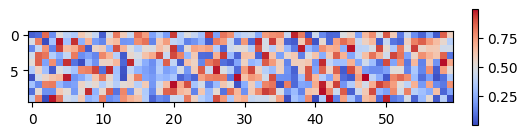

In [33]:
# Generate random data for the heatmap
data = np.random.rand(10, 60)

# Specify the figure size
plt.figure(figsize=(6, 6))

# Plot the heatmap using imshow
im = plt.imshow(data, cmap='coolwarm')

# Add a color bar
cb = plt.colorbar(im, fraction=0.046, pad=0.04, shrink=0.25)

# Show the plot
plt.show()